In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

from multiprocessing import Pool


sys.path.append("../functions")

from Utility import *
from Plotting import *
# from Forward import *
# from Backward import *

In [2]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]

chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]
# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]

subjects = lv_induction_data["sub"].unique()

In [3]:
from Utility import *
from scipy.optimize import minimize

def forward_LL(params, resps, rewards):
    alpha = params[0]
    beta = params[1]
    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    neg_LL = -np.sum(protected_log(resps_probabilities))
    return neg_LL

def model_subj_conf_dist(params, confs, resp_probs):
    lbound = params[0]
    hbound = params[1] * (5 - lbound) + lbound

    chosen_probs = resp_probs.copy()

    model_confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return mean_square_distance(confs, model_confs)

def minimize_func(d):
    
    params_ranges = d["params_ranges"]
    func = d["function"]
    func_args = d["func_args"]
    params0 = np.zeros(len(params_ranges))
    min_func = np.Inf
    fit_res = np.zeros(len(params_ranges))
    for p in range(len(params_ranges)):
        params0[p] = (np.random.uniform(*params_ranges[p]))
    fitting_result = minimize(func, x0=params0, args=func_args, bounds=params_ranges)
    if fitting_result.success:
        min_func = fitting_result.fun
        fit_res = fitting_result.x
    return fit_res, min_func

def fit_n_times(n_fitting, params_ranges, func, func_args):
    
    fitting_array = []
    for i in range(n_fitting):
        d = {"params_ranges": params_ranges, "function": func, "func_args": func_args}
        fitting_array.append(d)
    with Pool(n_fitting) as p:
        result = np.array(p.map(minimize_func, fitting_array), dtype=object)
    
    argmin = np.argmin(result[:,1])
    fit_res = result[argmin, 0]
    fit_val = result[argmin, 1]

    return fit_res, fit_val

def forward_probs(params, resps, rewards, *args):
    alpha = params[0]
    beta = params[1]
    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5])

    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    return resps_probabilities



def forward_fitting(n_fitting, resps, rewards, confs):
    """
    Fit data to forward model
    """
    params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]

    # choice params
    fit_res, neg_ll = fit_n_times(n_fitting, params_ranges[:2], forward_LL, (resps, rewards))

    alpha, beta = fit_res

    resp_probs = forward_probs(fit_res, resps, rewards)
    fit_res, conf_dist = fit_n_times(n_fitting, params_ranges[2:], model_subj_conf_dist, (confs, resp_probs))

    lbound, bound_range = fit_res

    fit_res = (alpha, beta, lbound, bound_range)

    return fit_res, neg_ll, conf_dist


In [4]:
def backward_distance(params, resps, rewards, confs):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3] * (5 - lbound) + lbound

    task_length = len(resps)
    resps_probabilities = np.zeros(task_length)
    Q = np.array([.5, .5])
    for t in range(task_length):
        choices_probability = softmax_func(Q, beta)
        resps_probabilities[t] = choices_probability[resps[t]]
        prediction_error = rewards[t] - Q[resps[t]]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    model_confs = linear_transform_on_array(resps_probabilities, [0, 1], [lbound, hbound])
    dist = mean_square_distance(confs, model_confs)
    return dist

def backward_fitting(n_fitting, resps, rewards, confs):
    
    params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
    
    fit_res, conf_dist = fit_n_times(n_fitting, params_ranges, backward_distance, (resps, rewards, confs))
    
    neg_LL = forward_LL(fit_res, resps, rewards)

    return fit_res, neg_LL, conf_dist


In [5]:
def simulate_agent2(params, trials_info):
    alpha = params[0]
    beta = params[1]

    lbound = params[2]
    hbound = params[3]
    
    Q = np.array([0.5, 0.5])
    Q_list = np.zeros((len(trials_info), 2))
    rewards = []
    resps = []
    chosen_probs = np.zeros(len(trials_info))

    acc = np.zeros(len(trials_info))
    for t, trial in enumerate(trials_info):
        Q_list[t, :] = Q
        correct_resp = trial[0]
        low_reward = trial[1]
        high_reward = trial[2]
        choices_probability = softmax_func(Q, beta)
        resp = np.random.choice([0, 1], p=choices_probability)
        chosen_probs[t] = choices_probability[resp]
        if resp == correct_resp:
            reward = high_reward
            acc[t] = 1
        else:
            acc[t] = 0
            reward = low_reward
        resps.append(resp)
        rewards.append(reward)
        prediction_error = reward - Q[resp]
        Q[resps[t]] = Q[resps[t]] + alpha * prediction_error

    confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return acc.mean()

def simulate_agent_n_times(params, trials_info, n = 100):
    from functools import partial
    
    
    fitting_array = []
    for i in range(n):
        fitting_array.append(params)
        
    f_part = partial(simulate_agent2, trials_info= trials_info)
    with Pool(n) as p:
        result = p.map(f_part, fitting_array)
    return np.mean(result)
    

In [6]:
def add_noise_to_conf(confs, scale):
    confs_cloned = confs.copy()
    noises =  np.random.normal(loc=0.0, scale=scale, size= len(confs))
    confs_cloned += noises
    confs_cloned[confs_cloned > 5] = 5
    confs_cloned[confs_cloned <1] = 1
    return confs_cloned

In [7]:
from Forward import simulate_agent

noise_stds = [0,1,2,4]
alpha_array = np.linspace(.05, 1, 10)
betas = [5, 15, 40]
mrls = np.zeros((len(alpha_array), len(betas), len(subjects),len(noise_stds)))
backward_perfs = np.zeros_like(mrls)
forward_perfs = np.zeros_like(mrls)
backward_dists = np.zeros_like(mrls)

lbound = 1
hbound = 5
n_fitting = 120

for i, alpha in enumerate(alpha_array):
    print("i = {}".format(i))
    for j, beta in enumerate(betas):
        params = [alpha, beta, lbound, hbound]
        for s, sub in enumerate(subjects):
            trials_info = get_subject_task(lv_induction_data, sub)
            resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)

            forward_params, forward_neg_LL, forward_dist = forward_fitting(n_fitting, resps, rewards, confs)
            forward_perf = simulate_agent_n_times(forward_params, trials_info, 100)
            forward_perfs[i, j, s,:] = forward_perf
            for n, noise in enumerate(noise_stds):
                if noise != 0:
                    noisy_confs = add_noise_to_conf(confs, noise)
                else: 
                    noisy_confs = confs.copy()
                
                backward_params, backward_neg_LL, backward_dist = backward_fitting(n_fitting, resps, rewards, noisy_confs)


                backward_perf = simulate_agent_n_times(forward_params, trials_info, 100)

                backward_perfs[i, j, s, n] = backward_perf
                mrls[i, j, s, n] = backward_perf/forward_perf
                backward_dists[i, j, s, n] = backward_dist

i = 0


KeyboardInterrupt: 

In [12]:
np.savez('../results/learning_aspects', mrls=mrls, backward_perfs=backward_perfs, forward_perfs= forward_perfs, backward_dists = backward_dists)


In [8]:
alpha_res = np.load("../results/learning_aspects.npz")

In [9]:
alpha_array = np.linspace(.05, 1, 11)
alpha_array

array([0.05 , 0.145, 0.24 , 0.335, 0.43 , 0.525, 0.62 , 0.715, 0.81 ,
       0.905, 1.   ])

In [10]:
mrls = alpha_res["mrls"]
alpha_array = np.linspace(.05, 1, 10)
betas = [5, 15, 40]
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

lr_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])

In [30]:
beta_agg_df

,alpha,beta,subject,Noise-SD,mrl
0,0.2,5.0,45628,0,1.002422
1,0.2,5.0,45628,1,0.971718
2,0.2,5.0,45628,2,0.969036
3,0.2,5.0,45628,4,0.960733
4,0.2,5.0,45640,0,0.994826
...,...,...,...,...,...
6475,0.9,90.0,47740,4,0.907984
6476,0.9,90.0,47743,0,1.001610
6477,0.9,90.0,47743,1,1.070828
6478,0.9,90.0,47743,2,0.986228


/tmp/ipykernel_73698/4110578007.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].astype(int)
/tmp/ipykernel_73698/4110578007.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].astype(int)
/tmp/ipykernel_73698/4110578007.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

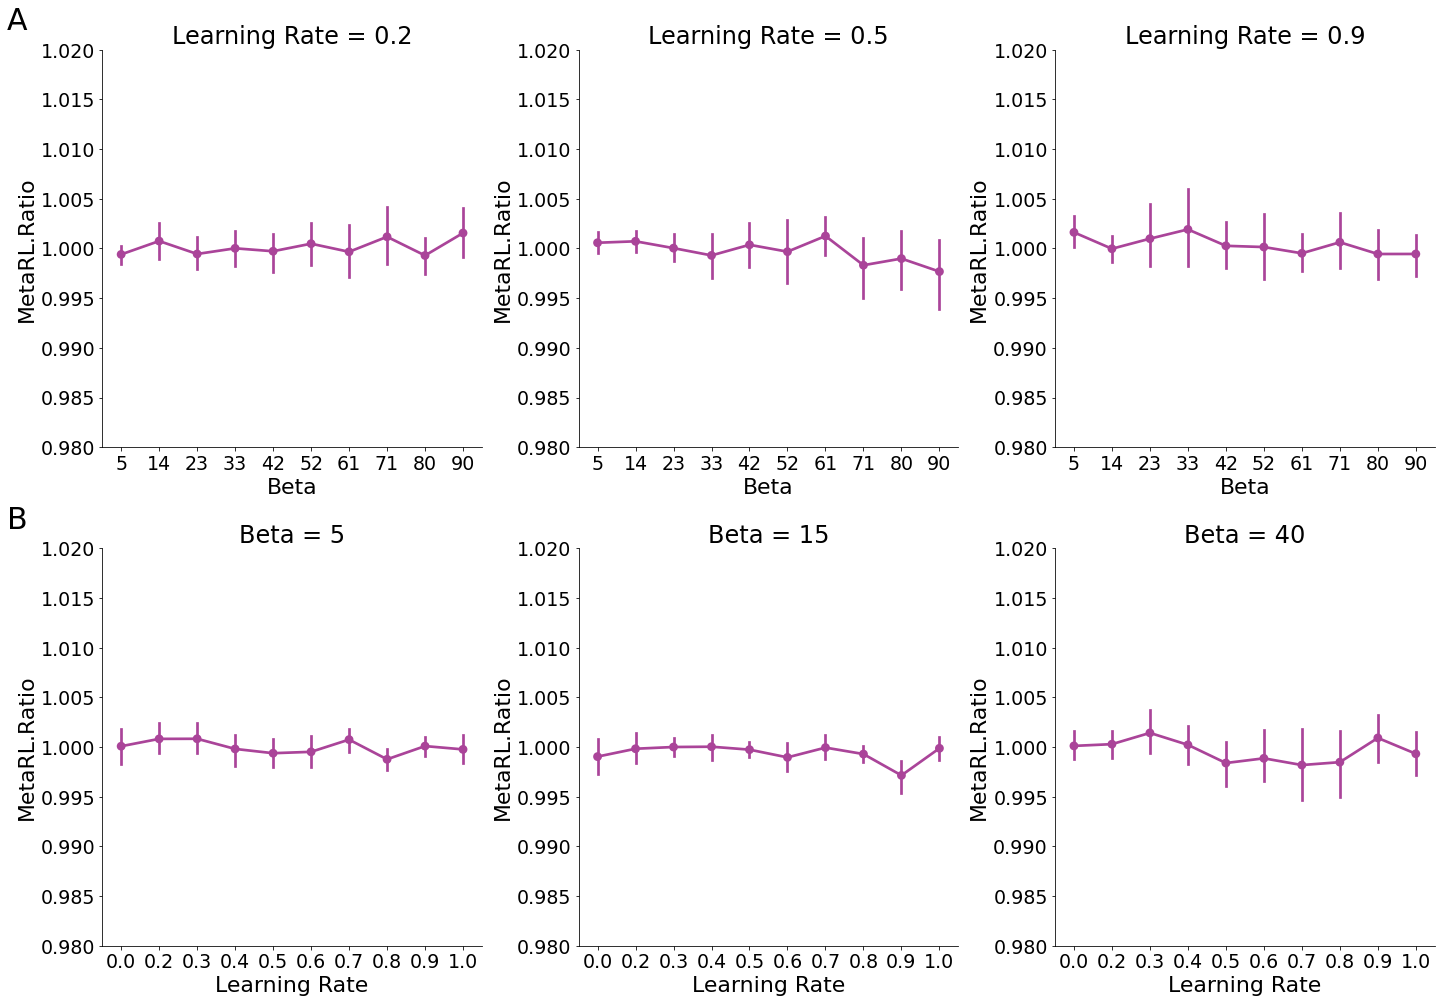

In [39]:
plt.subplots(figsize=(20, 14))

from matplotlib.ticker import FormatStrFormatter

beta_res = np.load("../results/learning_aspects_beta.npz")
mrls = beta_res["mrls"]
alpha_array = [.2, .5, .9]
betas = np.linspace(5, 90, 10)
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

beta_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])


for i in range(len(alpha_array)):
    plt.subplot(2, 3, i+1)
    if i == 0:
        plt.text(-3, 1.022, "A", fontsize=30)
    alpha_df = beta_agg_df[beta_agg_df["alpha"] == alpha_array[i]]
    alpha_df["beta"] = alpha_df["beta"].astype(int)
    clrs = ["#2C041C", "#8F00FF", "#DA70D6", "#D8BFD8"]
    # for noise, clr in zip(noise_stds, clrs):
    #     beta_df_nois= beta_df[beta_df["noise"] == noise]
    #     seaborn.pointplot(beta_df_nois, x = "alpha", y = "mrl", color= clr)
    
    
    alpha_0 = alpha_df[alpha_df["Noise-SD"] == 0]
    seaborn.pointplot(alpha_0, x = "beta", y = "mrl", color = "#AA4499")

    plt.title("Learning Rate = {}".format(alpha_array[i]), fontsize=24)
    plt.xlabel("Beta", fontsize=22)
    plt.ylabel("MetaRL.Ratio", fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    ax = plt.gca()
    plt.ylim([.98, 1.02])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
alpha_res = np.load("../results/learning_aspects.npz")

mrls = alpha_res["mrls"]
alpha_array = np.linspace(.05, 1, 10)
betas = [5, 15, 40]
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

lr_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])

betas = [5, 15, 40]
for i in range(len(betas)):
    plt.subplot(2, 3, i+4)
    if i == 0:
        plt.text(-3, 1.022, "B", fontsize=30)
    beta_df = lr_agg_df[lr_agg_df["beta"] == betas[i]]
    beta_df["alpha"] = beta_df["alpha"].round(1)
    clrs = ["#2C041C", "#8F00FF", "#DA70D6", "#D8BFD8"]
    # for noise, clr in zip(noise_stds, clrs):
    #     beta_df_nois= beta_df[beta_df["noise"] == noise]
    #     seaborn.pointplot(beta_df_nois, x = "alpha", y = "mrl", color= clr)
    beta_0 = beta_df[beta_df["Noise-SD"] == 0]

    seaborn.pointplot(beta_0, x = "alpha", y = "mrl", color= "#AA4499")

    plt.title("Beta = {}".format(betas[i]), fontsize=24)
    plt.xlabel("Learning Rate", fontsize=22)
    plt.ylabel("MetaRL.Ratio", fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=19)
    plt.ylim([.98, 1.02])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/Indep_Forwardparam.png", bbox_inches = "tight")

In [89]:
lr_agg_df[lr_agg_df["Noise-SD"] == 0]["mrl"].std()

0.006770154364023408

In [ ]:
plt.figure(figsize=(8, 7))

plt.plot(alpha_array, mean_backward_dists[:,0,0], color = "red", lw = 3 , label = "Meta.RL ")
plt.plot(alpha_array, mean_backward_dists[:,0,1], color = "red", lw = 3 , label = "Meta.RL ", alpha = .5)
plt.xlabel("learning rate", fontsize=24)
plt.ylabel("Conf distance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8, 7))

plt.plot(alpha_array, mean_forward_perfs[:,0,0], color = "blue", lw = 3 , label = "Meta.RL ")
plt.plot(alpha_array, mean_backward_perfs[:,0,0], color = "red", lw = 3 , label = "Meta.RL ", alpha = 1)
plt.plot(alpha_array, mean_backward_perfs[:,0,1], color = "red", lw = 3 , label = "Meta.RL ", alpha = .5)

plt.xlabel("learning rate", fontsize=24)
plt.ylabel("Performance", fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=24)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
from Forward import simulate_agent

noise_stds = [0,1,2,4]
alpha_array = [.2, .5, .9]
betas = np.linspace(5, 90, 10)
mrls = np.zeros((len(alpha_array), len(betas), len(subjects),len(noise_stds)))
backward_perfs = np.zeros_like(mrls)
forward_perfs = np.zeros_like(mrls)
backward_dists = np.zeros_like(mrls)

lbound = 1
hbound = 5
n_fitting = 120

for i, alpha in enumerate(alpha_array):
    print("i = {}".format(i))
    for j, beta in enumerate(betas):
        params = [alpha, beta, lbound, hbound]
        for s, sub in enumerate(subjects):
            trials_info = get_subject_task(lv_induction_data, sub)
            resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)

            forward_params, forward_neg_LL, forward_dist = forward_fitting(n_fitting, resps, rewards, confs)
            forward_perf = simulate_agent_n_times(forward_params, trials_info, 100)
            forward_perfs[i, j, s,:] = forward_perf
            for n, noise in enumerate(noise_stds):
                if noise != 0:
                    noisy_confs = add_noise_to_conf(confs, noise)
                else: 
                    noisy_confs = confs.copy()
                
                backward_params, backward_neg_LL, backward_dist = backward_fitting(n_fitting, resps, rewards, noisy_confs)


                backward_perf = simulate_agent_n_times(forward_params, trials_info, 100)

                backward_perfs[i, j, s, n] = backward_perf
                mrls[i, j, s, n] = backward_perf/forward_perf
                backward_dists[i, j, s, n] = backward_dist

In [15]:
np.savez('../results/learning_aspects_beta', mrls=mrls, backward_perfs=backward_perfs, forward_perfs= forward_perfs, backward_dists = backward_dists)

In [72]:
beta_res = np.load("../results/learning_aspects_beta.npz")
mrls = beta_res["mrls"]
alpha_array = [.2, .5, .9]
betas = np.linspace(5, 90, 10)
alpha_ls = []
beta_ls = []
subject_ls = []
noise_ls = []
mrls_ls = []
for i in range(len(alpha_array)):
    for j in range(len(betas)):
        for l in range(len(subjects)):
            for m in range(len(noise_stds)):
                alpha_ls.append(alpha_array[i])
                beta_ls.append(betas[j])
                subject_ls.append(subjects[l])
                noise_ls.append(noise_stds[m])
                mrls_ls.append(mrls[i,j,l,m])

beta_agg_df = pd.DataFrame(zip(alpha_ls, beta_ls, subject_ls, noise_ls, mrls_ls), columns=["alpha", "beta", "subject", "Noise-SD", "mrl"])

In [71]:
mrls.shape

(10, 3, 54, 4)

/tmp/ipykernel_35439/3279747375.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].round()
/tmp/ipykernel_35439/3279747375.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_df["beta"] = alpha_df["beta"].round()
/tmp/ipykernel_35439/3279747375.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

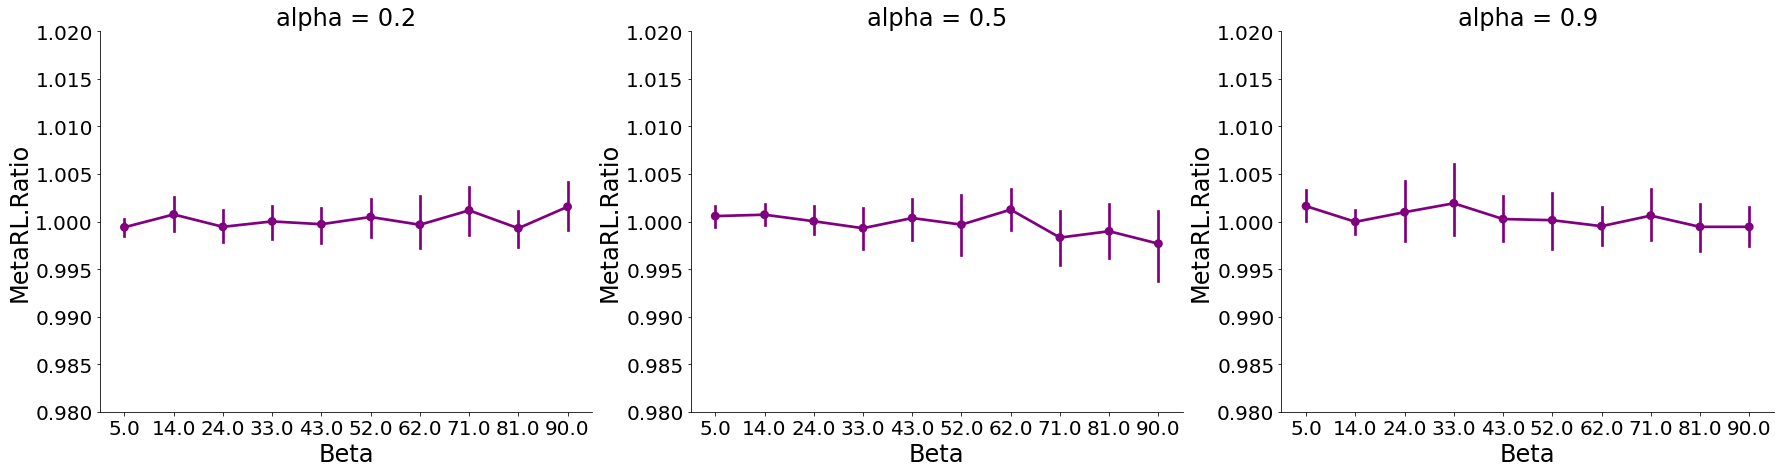

In [110]:
plt.subplots(figsize=(30, 7))

from matplotlib.ticker import StrMethodFormatter

alpha_array = [.2, .5, .9]

for i in range(len(alpha_array)):
    plt.subplot(1, 3, i+1)
    alpha_df = beta_agg_df[beta_agg_df["alpha"] == alpha_array[i]]
    alpha_df["beta"] = alpha_df["beta"].round()
    clrs = ["#2C041C", "#8F00FF", "#DA70D6", "#D8BFD8"]
    # for noise, clr in zip(noise_stds, clrs):
    #     beta_df_nois= beta_df[beta_df["noise"] == noise]
    #     seaborn.pointplot(beta_df_nois, x = "alpha", y = "mrl", color= clr)
    
    
    alpha_0 = alpha_df[alpha_df["Noise-SD"] == 0]
    seaborn.pointplot(alpha_0, x = "beta", y = "mrl", color = "purple")

    plt.title("alpha = {}".format(alpha_array[i]), fontsize=24)
    plt.xlabel("Beta", fontsize=24)
    plt.ylabel("MetaRL.Ratio", fontsize=24)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    ax = plt.gca()
    plt.ylim([.98, 1.02])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.savefig("../figs/beta_indep.png", bbox_inches = "tight")

In [91]:
beta_agg_df[beta_agg_df["Noise-SD"] == 0]["mrl"].mean()

1.0000760604096477